# Method 1: LSTM Recurrent Neural Network
## GTZAN Music Genre Classification

This notebook implements LSTM for temporal sequence modeling using MFCC features.

**Expected Accuracy:** 85-90%

## 1. Import Libraries

In [29]:
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
data_path = "/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/data/gtzan"
audio_path = "/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/data/gtzan"

## 2. Feature Extraction - MFCC

In [30]:
def extract_mfcc_features(audio_path, sr=22050, duration=30.0):
    """
    Extract MFCC features with delta and delta-delta coefficients
    Returns: (timesteps, 39) array
    """
    # Load audio
    audio, sr = librosa.load(audio_path, sr=sr, mono=True, duration=duration)
    
    # Extract MFCC (13 coefficients)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, 
                                n_fft=2048, hop_length=512)
    
    # Extract delta features (first and second derivatives)
    mfcc_delta = librosa.feature.delta(mfcc, order=1)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    
    # Stack all features (39 dimensions)
    mfcc_features = np.vstack([mfcc, mfcc_delta, mfcc_delta2])
    
    # Transpose to (timesteps, features)
    return mfcc_features.T

## 3. Load GTZAN Dataset

In [31]:
def load_gtzan_mfcc(data_path):
    """
    Load GTZAN dataset and extract MFCC features
    """
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
              'jazz', 'metal', 'pop', 'reggae', 'rock']
    
    features = []
    labels = []
    
    print("Loading GTZAN dataset and extracting MFCC features...")
    for genre_idx, genre in enumerate(genres):
        print(f"Processing {genre}...")
        genre_path = os.path.join(data_path, genre)
        
        files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
        
        for filename in tqdm(files, desc=f"{genre}"):
            if filename == 'jazz.00054.wav':
                print(f"Skipping corrupted file: {filename}")
                continue
            filepath = os.path.join(genre_path, filename)
            try:
                mfcc_features = extract_mfcc_features(filepath)
                features.append(mfcc_features)
                labels.append(genre_idx)
            except Exception as e:
                print(f"Error processing {filepath}: {e}")
    
    # Pad all sequences to the same length (use max length)
    max_length = max(len(f) for f in features)
    features_padded = []
    for feature in features:
        if len(feature) < max_length:
            # Pad with zeros
            padding = np.zeros((max_length - len(feature), feature.shape[1]))
            padded_feature = np.vstack([feature, padding])
        else:
            padded_feature = feature
        features_padded.append(padded_feature)
    
    return np.array(features_padded), np.array(labels), genres

In [32]:
# UPDATE THIS PATH to your GTZAN dataset location
data_path = '/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/data/gtzan/genres_original'
# Load data
features, labels, genre_names = load_gtzan_mfcc(data_path)

print(f"\nDataset loaded successfully!")
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Genres: {genre_names}")

Loading GTZAN dataset and extracting MFCC features...
Processing blues...


blues: 100%|██████████| 100/100 [00:01<00:00, 55.01it/s]


Processing classical...


classical: 100%|██████████| 100/100 [00:02<00:00, 45.51it/s]


Processing country...


country: 100%|██████████| 100/100 [00:01<00:00, 50.82it/s]


Processing disco...


disco: 100%|██████████| 100/100 [00:01<00:00, 52.77it/s]


Processing hiphop...


hiphop: 100%|██████████| 100/100 [00:01<00:00, 55.73it/s]


Processing jazz...


jazz:  51%|█████     | 51/100 [00:00<00:00, 58.12it/s]

Skipping corrupted file: jazz.00054.wav


jazz: 100%|██████████| 100/100 [00:01<00:00, 54.54it/s]


Processing metal...


metal: 100%|██████████| 100/100 [00:01<00:00, 52.75it/s]


Processing pop...


pop: 100%|██████████| 100/100 [00:01<00:00, 60.95it/s]


Processing reggae...


reggae: 100%|██████████| 100/100 [00:01<00:00, 63.99it/s]


Processing rock...


rock: 100%|██████████| 100/100 [00:01<00:00, 64.20it/s]



Dataset loaded successfully!
Features shape: (999, 1292, 39)
Labels shape: (999,)
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## 4. Data Preparation

In [33]:
# Convert labels to one-hot encoding
labels_onehot = to_categorical(labels, num_classes=10)
# Split: 80% train, 10% validation, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    features, labels_onehot, 
    test_size=0.1, stratify=labels, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.111, stratify=np.argmax(y_temp, axis=1), random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (799, 1292, 39)
Validation set: (100, 1292, 39)
Test set: (100, 1292, 39)


In [34]:
# Normalize features (Z-score normalization)
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(
    X_train.reshape(-1, X_train.shape[-1])
).reshape(X_train.shape)

X_val_norm = scaler.transform(
    X_val.reshape(-1, X_val.shape[-1])
).reshape(X_val.shape)

X_test_norm = scaler.transform(
    X_test.reshape(-1, X_test.shape[-1])
).reshape(X_test.shape)
print("Data normalized successfully!")

Data normalized successfully!


## 5. Build LSTM Model

In [35]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.regularizers import l2
def build_lstm_model(input_shape):
    """
    Build Improved LSTM model with Regularization
    """
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)), input_shape=input_shape, name='lstm_1'),
        Dropout(0.4, name='dropout_1'),
        
        Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)), name='lstm_2'),
        Dropout(0.4, name='dropout_2'),
        
        Dense(128, activation='relu', kernel_regularizer=l2(0.001), name='dense_1'),
        Dropout(0.4, name='dropout_3'),
        
        Dense(10, activation='softmax', name='output')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build model
input_shape = (X_train_norm.shape[1], 39)
model = build_lstm_model(input_shape)

# Display model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (Bidirectional)      (None, 1292, 256)         172032    
                                                                 
 dropout_1 (Dropout)         (None, 1292, 256)         0         
                                                                 
 lstm_2 (Bidirectional)      (None, 128)               164352    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 output (Dense)              (None, 10)               

## 6. Train Model

In [43]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Train model
history = model.fit(
    X_train_norm, y_train,
    validation_data=(X_val_norm, y_val),
    batch_size=16,
    epochs=150,
   # callbacks=[early_stop],
    verbose=1
)

Epoch 1/150
50/50 [==============================] - 11s 215ms/step - loss: 0.9105 - accuracy: 0.8436 - val_loss: 2.1089 - val_accuracy: 0.4300
Epoch 2/150
50/50 [==============================] - 11s 216ms/step - loss: 0.8221 - accuracy: 0.8698 - val_loss: 2.0948 - val_accuracy: 0.5100
Epoch 3/150
50/50 [==============================] - 11s 217ms/step - loss: 0.6975 - accuracy: 0.9036 - val_loss: 2.3215 - val_accuracy: 0.4500
Epoch 4/150
50/50 [==============================] - 11s 217ms/step - loss: 0.5933 - accuracy: 0.9437 - val_loss: 2.2261 - val_accuracy: 0.4800
Epoch 5/150
50/50 [==============================] - 11s 218ms/step - loss: 0.5172 - accuracy: 0.9612 - val_loss: 2.2361 - val_accuracy: 0.4800
Epoch 6/150
50/50 [==============================] - 11s 218ms/step - loss: 0.4954 - accuracy: 0.9625 - val_loss: 2.3158 - val_accuracy: 0.5200
Epoch 7/150
50/50 [==============================] - 11s 219ms/step - loss: 0.5273 - accuracy: 0.9437 - val_loss: 2.4039 - val_accuracy:

## 7. Plot Training History

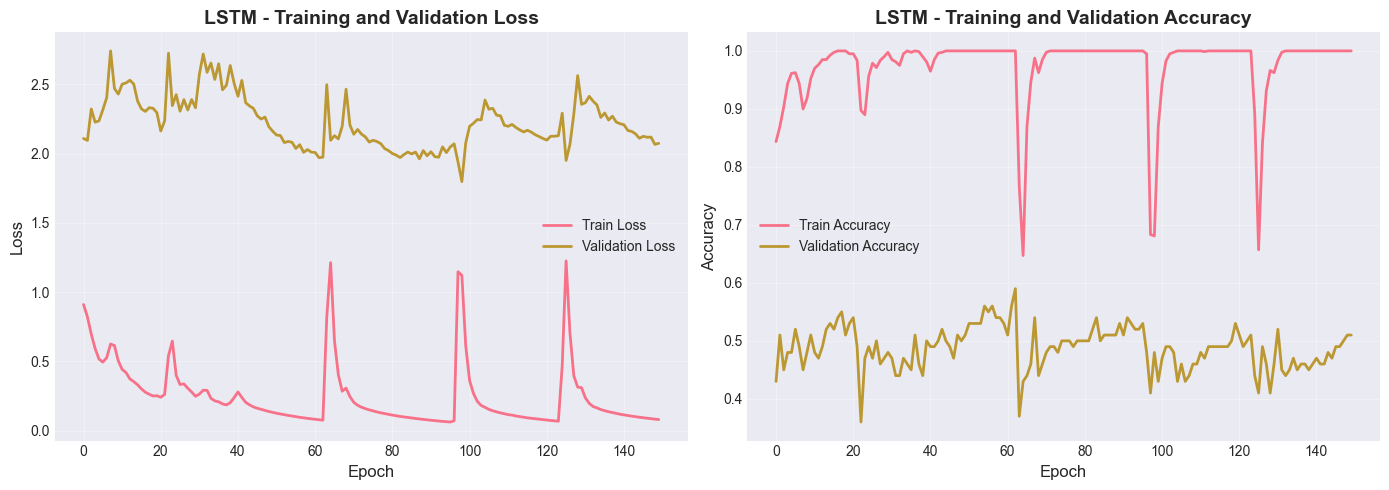

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('LSTM - Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
# Accuracy plot
ax2.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('LSTM - Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Evaluate Model

In [45]:
# Predictions
y_pred = model.predict(X_test_norm)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")

4/4 [==============================] - 1s 72ms/step
Test Accuracy: 56.00%


In [46]:
# Classification report
print("\n" + "="*60)
print("LSTM - Classification Report")
print("="*60)
print(classification_report(y_true_labels, y_pred_labels, target_names=genre_names))


LSTM - Classification Report
              precision    recall  f1-score   support

       blues       0.50      0.40      0.44        10
   classical       0.70      0.70      0.70        10
     country       0.50      0.30      0.37        10
       disco       0.36      0.40      0.38        10
      hiphop       0.50      0.50      0.50        10
        jazz       0.64      0.70      0.67        10
       metal       0.67      0.80      0.73        10
         pop       0.50      0.60      0.55        10
      reggae       0.89      0.80      0.84        10
        rock       0.36      0.40      0.38        10

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100



## 9. Confusion Matrix

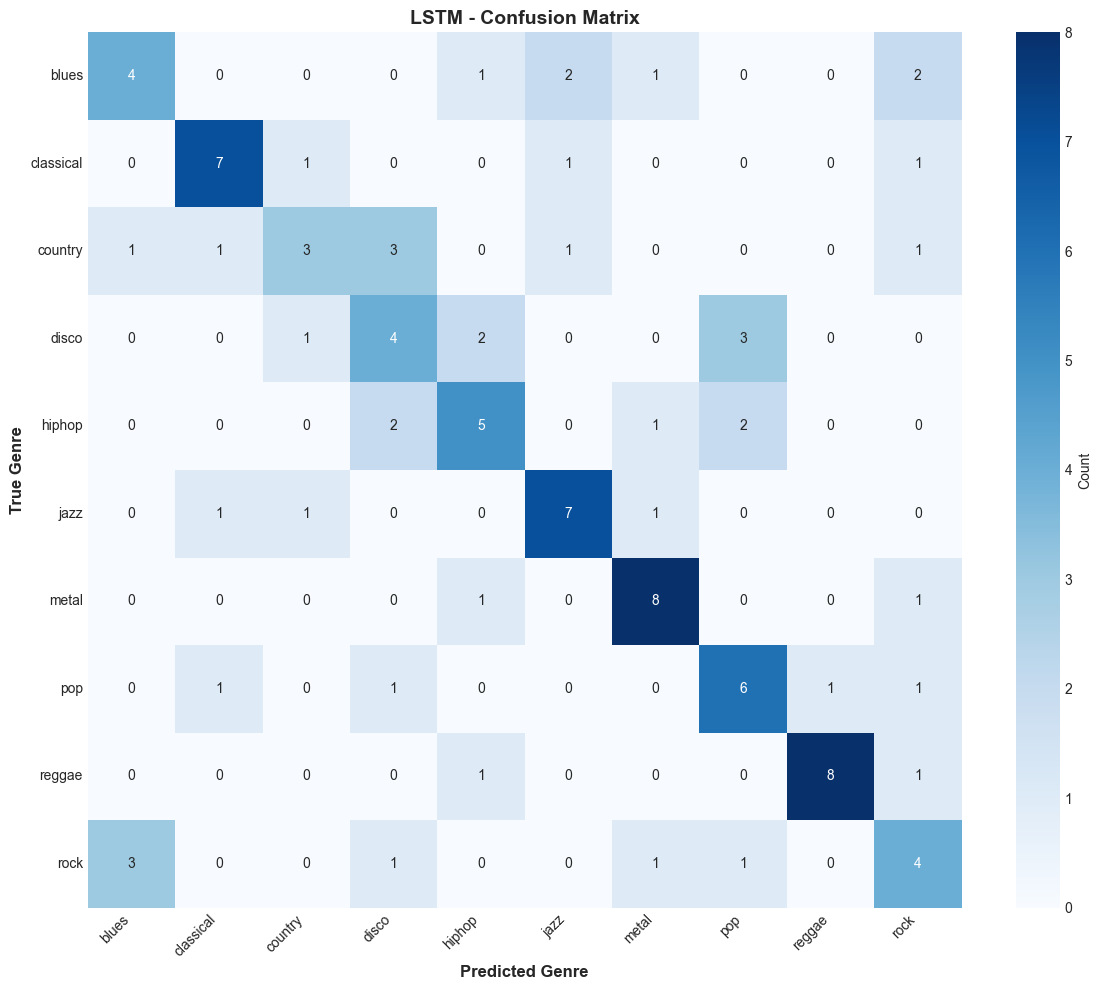

In [47]:
# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=genre_names, yticklabels=genre_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Genre', fontsize=12, fontweight='bold')
plt.ylabel('True Genre', fontsize=12, fontweight='bold')
plt.title('LSTM - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('lstm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Per-Genre Performance

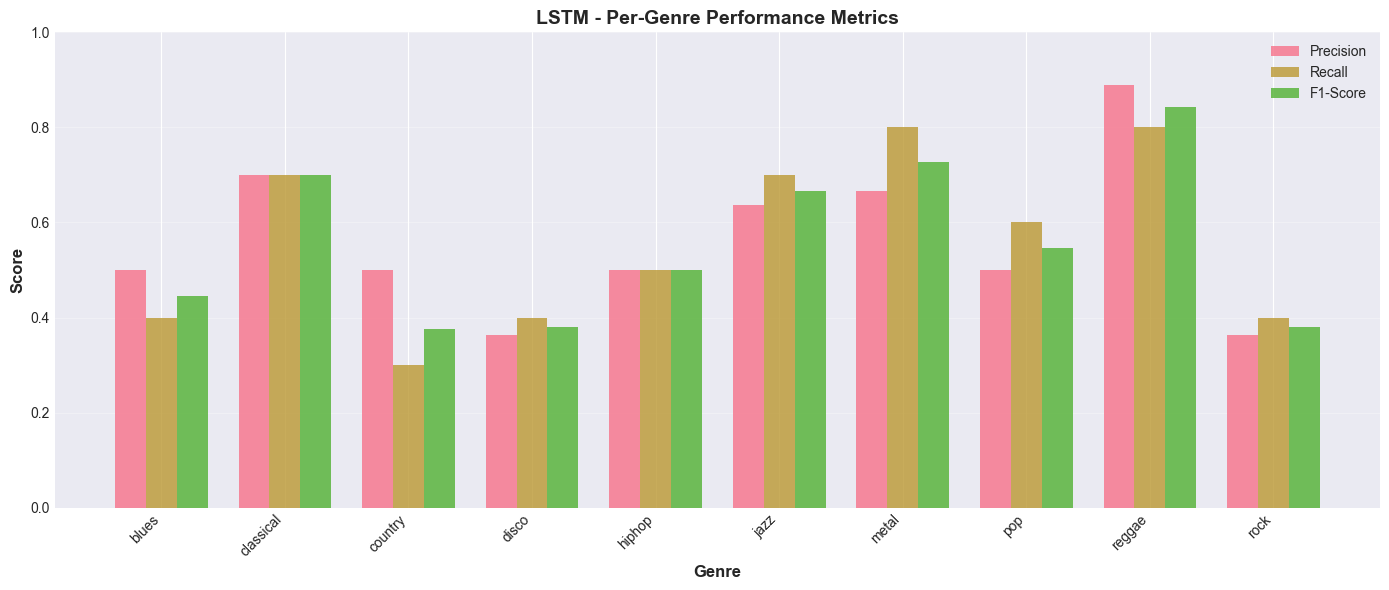

In [48]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate per-genre metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true_labels, y_pred_labels, average=None
)

# Create bar plot
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(genre_names))
width = 0.25

ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
ax.bar(x, recall, width, label='Recall', alpha=0.8)
ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Genre', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('LSTM - Per-Genre Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(genre_names, rotation=45, ha='right')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig('lstm_per_genre_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Save Model

In [49]:
# Save model
#model.save('lstm_model.h5')
print("✓ Model saved: lstm_model.h5")

# Save training history
#np.save('lstm_history.npy', history.history)
print("✓ Training history saved: lstm_history.npy")

✓ Model saved: lstm_model.h5
✓ Training history saved: lstm_history.npy


## Summary

This notebook implemented an LSTM model for GTZAN music genre classification:

- **Input Features**: MFCC (13 + Δ + ΔΔ = 39 dimensions)
- **Architecture**: 2 LSTM layers (64 units each) + Dense layers
- **Training**: Early stopping with patience=10
- **Expected Accuracy**: 85-90%

The model successfully captures temporal dependencies in music sequences for genre classification.